In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from torchinfo import summary
import matplotlib.pyplot as plt
import time
import joblib

In [2]:
torch.__version__

'2.5.1+cpu'

In [3]:
df = pd.read_csv("data/gym_churn_us.csv")

In [4]:
X = df.drop(columns=['Churn','Avg_class_frequency_current_month','Month_to_end_contract','Phone'])
y = df['Churn']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
X_train.shape, X_valid.shape,y_train.shape, y_valid.shape

((3200, 10), (800, 10), (3200,), (800,))

In [6]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)

In [7]:
# 텐서로 변환
X_train = torch.tensor(X_train, dtype=torch.float32)
X_valid = torch.tensor(X_valid, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
y_valid = torch.tensor(y_valid.values, dtype=torch.float32).view(-1, 1)

In [8]:
print(X_train.shape, y_train.size())
print(X_train.dtype, y_train.dtype)
X_train.type()

torch.Size([3200, 10]) torch.Size([3200, 1])
torch.float32 torch.float32


'torch.FloatTensor'

In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cpu


In [10]:
epochs = 100
batch_size = 128
lr = 0.001

In [11]:
trainset = TensorDataset(X_train, y_train)
validset = TensorDataset(X_valid, y_valid)

train_loader = DataLoader(trainset, batch_size=32, shuffle=True)
valid_loader = DataLoader(validset, batch_size=32, shuffle=False)

In [12]:
def test_multi_classification(dataloader, model, loss_fn, device="cpu") -> tuple:
    """
    다중 분류 검증/평가 함수
    
    [parameter]
        dataloader: DataLoader - 검증할 대상 데이터로더
        model: 검증할 모델
        loss_fn: 모델 추정값과 정답의 차이를 계산할 loss 함수.
        device: str - 연산을 처리할 장치. default-"cpu", gpu-"cuda"
    [return]
        tuple: (loss, accuracy)
    """
    model.to(device)
    model.eval() 
    size = len(dataloader.dataset)
    num_steps = len(dataloader)
    
    test_loss, test_accuracy = 0., 0.
    
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            # 정확도 계산
            pred_label = torch.argmax(pred, axis=-1)
            test_accuracy += torch.sum(pred_label == y).item()
            
        test_loss /= num_steps
        test_accuracy /= size
    return test_loss, test_accuracy

def test_binary_classification(dataloader, model, loss_fn, device="cpu") -> tuple:
    """
    이진 분류 검증/평가 함수
    
    [parameter]
        dataloader: DataLoader - 검증할 대상 데이터로더
        model: 검증할 모델
        loss_fn: 모델 추정값과 정답의 차이를 계산할 loss 함수.
        device: str - 연산을 처리할 장치. default-"cpu", gpu-"cuda"
    [return]
        tuple: (loss, accuracy)
    """
    model.to(device)
    model.eval() # 모델을 평가모드로 변환
    size = len(dataloader.dataset)
    num_steps = len(dataloader)
    
    test_loss, test_accuracy = 0., 0.
    
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            ## 정확도 계산
            pred_label = (pred >= 0.5).type(torch.int32)
            test_accuracy += (pred_label == y).sum().item() 
            
        test_loss /= num_steps
        test_accuracy /= size   #전체 개수로 나눈다.
    return test_loss, test_accuracy    

def train(dataloader, model, loss_fn, optimizer, device="cpu", mode:"binary or multi"='binary'):
    """
    모델을 1 epoch 학습시키는 함수

    [parameter]
        dataloader: DataLoader - 학습데이터셋을 제공하는 DataLoader
        model - 학습대상 모델
        loss_fn: 모델 추정값과 정답의 차이를 계산할 loss 함수.
        optimizer - 최적화 함수
        device: str - 연산을 처리할 장치. default-"cpu", gpu-"cuda"
        mode: str - 분류 종류. binary 또는 multi
    [return]
        tuple: 학습후 계산한 Train set에 대한  train_loss, train_accuracy
    """
    model.train()
    size = len(dataloader.dataset) 

    for X, y in dataloader:
        X, y = X.to(device), y.to(device)
        pred = model(X)

        loss = loss_fn(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    if mode == 'binary':
        train_loss, train_accuracy = test_binary_classification(dataloader, model, loss_fn, device)
    else:
        train_loss, train_accuracy = test_multi_classification(dataloader, model, loss_fn, device)
    return train_loss, train_accuracy



def fit(train_loader, val_loader, model, loss_fn, optimizer, epochs, save_best_model=True, 
        save_model_path=None, early_stopping=True, patience=10, device='cpu',  mode:"binary or multi"='binary',
        lr_scheduler=None):
    """
    모델을 학습시키는 함수

    [parameter]
        train_loader (Dataloader): Train dataloader
        test_loader (Dataloader): validation dataloader
        model (Module): 학습시킬 모델
        loss_fn (_Loss): Loss function
        optimizer (Optimizer): Optimizer
        epochs (int): epoch수
        save_best_model (bool, optional): 학습도중 성능개선시 모델 저장 여부. Defaults to True.
        save_model_path (str, optional): save_best_model=True일 때 모델저장할 파일 경로. Defaults to None.
        early_stopping (bool, optional): 조기 종료 여부. Defaults to True.
        patience (int, optional): 조기종료 True일 때 종료전에 성능이 개선될지 몇 epoch까지 기다릴지 epoch수. Defaults to 10.
        device (str, optional): device. Defaults to 'cpu'.
        mode(str, optinal): 분류 종류. "binary(default) or multi
        lr_scheduler: Learning Rate Scheduler 객체. default: None, Epoch 단위로 LR 를 변경.
    [return]
        tuple: 에폭 별 성능 리스트. (train_loss_list, train_accuracy_list, validation_loss_list, validataion_accuracy_list)
    """

    train_loss_list = []
    train_accuracy_list = []
    val_loss_list = []
    val_accuracy_list = []
    
        
    if save_best_model:
        best_score_save = torch.inf

    ############################
    # early stopping
    #############################
    if early_stopping:
        trigger_count = 0
        best_score_es = torch.inf
    
    # 모델 device로 옮기기
    model = model.to(device)
    s = time.time()
    for epoch in range(epochs):
        train_loss, train_accuracy = train(train_loader, model, loss_fn, optimizer, device=device, mode=mode)
        ############ 1 epoch 학습 종료 -> LR 를 변경 ###########
        if lr_scheduler is not None:
            current_lr = lr_scheduler.get_last_lr()[0]  # log용
            lr_scheduler.step()
            new_lr = lr_scheduler.get_last_lr()[0] # log용
            if current_lr != new_lr: # LR가 변경되었으면
                print(f">>>>>>Learning Rate가 {current_lr}에서 {new_lr}로 변경됨<<<<<<")

        
        if mode == "binary":
            val_loss, val_accuracy = test_binary_classification(val_loader, model, loss_fn, device=device)
        else:
            val_loss, val_accuracy = test_multi_classification(val_loader, model, loss_fn, device=device)

        train_loss_list.append(train_loss)
        train_accuracy_list.append(train_accuracy)
        val_loss_list.append(val_loss)
        val_accuracy_list.append(val_accuracy)
        
        print(f"Epoch[{epoch+1}/{epochs}] - Train loss: {train_loss:.5f} Train Accucracy: {train_accuracy:.5f} || Validation Loss: {val_loss:.5f} Validation Accuracy: {val_accuracy:.5f}")
        print('='*100)
        
        # 모델 저장
        if save_best_model:
            if val_loss < best_score_save:
                torch.save(model, save_model_path)
                print(f"저장: {epoch+1} - 이전 : {best_score_save}, 현재: {val_loss}")
                best_score_save = val_loss
        
        # early stopping 처리            
        if early_stopping:
            if val_loss < best_score_es: 
                best_score_es = val_loss  
                trigger_count = 0
                                
            else:
                trigger_count += 1                
                if patience == trigger_count:
                    print(f"Early stopping: Epoch - {epoch}")
                    break
            
    e = time.time()
    print(e-s, "초")
    return train_loss_list, train_accuracy_list, val_loss_list, val_accuracy_list

In [13]:
class DropoutModel(nn.Module):

    def __init__(self, dropout_rate=0.5):
        super().__init__()
        self.lr1 = nn.Sequential(nn.Linear(X_train.shape[1], 128), nn.ReLU(), nn.Dropout(p=dropout_rate))
        self.lr2 = nn.Sequential(nn.Linear(128, 64), nn.ReLU(), nn.Dropout(p=dropout_rate))
        self.lr3 = nn.Sequential(nn.Linear(64, 32), nn.ReLU(), nn.Dropout(p=dropout_rate))
        self.lr4 = nn.Sequential(nn.Linear(32,16), nn.ReLU(), nn.Dropout(p=dropout_rate))
        self.out_block = nn.Linear(16, 1)
    
    def forward(self, X):
        X = nn.Flatten()(X)
        X = self.lr1(X)
        X = self.lr2(X)
        X = self.lr3(X)
        X = self.lr4(X)
        output = self.out_block(X)
        output = torch.sigmoid(output)
        return output    

In [14]:
dout_model = DropoutModel().to(device)
summary(dout_model, (10, X_train.shape[1]), device=device)

Layer (type:depth-idx)                   Output Shape              Param #
DropoutModel                             [10, 1]                   --
├─Sequential: 1-1                        [10, 128]                 --
│    └─Linear: 2-1                       [10, 128]                 1,408
│    └─ReLU: 2-2                         [10, 128]                 --
│    └─Dropout: 2-3                      [10, 128]                 --
├─Sequential: 1-2                        [10, 64]                  --
│    └─Linear: 2-4                       [10, 64]                  8,256
│    └─ReLU: 2-5                         [10, 64]                  --
│    └─Dropout: 2-6                      [10, 64]                  --
├─Sequential: 1-3                        [10, 32]                  --
│    └─Linear: 2-7                       [10, 32]                  2,080
│    └─ReLU: 2-8                         [10, 32]                  --
│    └─Dropout: 2-9                      [10, 32]                  --
├─Sequ

In [15]:
loss_fn =nn.BCELoss()
optimizer = torch.optim.Adam(dout_model.parameters(), lr=lr)

In [16]:
train_loss_list, train_acc_list, valid_loss_list, valid_acc_list = fit(
    train_loader, valid_loader, # dataLoader
    dout_model, loss_fn, optimizer, 
    epochs,
    save_model_path="models/dout_model.pt",
    patience=10,
    device=device,
    mode='binary'
)
# 학습 완료 후 모델 저장
joblib.dump(scaler, "models/scaler.pkl")
print("모델이 저장되었습니다.")

Epoch[1/100] - Train loss: 0.36509 Train Accucracy: 0.73156 || Validation Loss: 0.35884 Validation Accuracy: 0.74750
저장: 1 - 이전 : inf, 현재: 0.35884382724761965
Epoch[2/100] - Train loss: 0.28665 Train Accucracy: 0.89500 || Validation Loss: 0.28706 Validation Accuracy: 0.89500
저장: 2 - 이전 : 0.35884382724761965, 현재: 0.28706049144268037
Epoch[3/100] - Train loss: 0.24498 Train Accucracy: 0.90125 || Validation Loss: 0.24949 Validation Accuracy: 0.89750
저장: 3 - 이전 : 0.28706049144268037, 현재: 0.24948866724967955
Epoch[4/100] - Train loss: 0.23667 Train Accucracy: 0.90438 || Validation Loss: 0.24235 Validation Accuracy: 0.89250
저장: 4 - 이전 : 0.24948866724967955, 현재: 0.2423454624414444
Epoch[5/100] - Train loss: 0.23162 Train Accucracy: 0.90687 || Validation Loss: 0.24002 Validation Accuracy: 0.90000
저장: 5 - 이전 : 0.2423454624414444, 현재: 0.2400249719619751
Epoch[6/100] - Train loss: 0.22822 Train Accucracy: 0.90719 || Validation Loss: 0.23812 Validation Accuracy: 0.90250
저장: 6 - 이전 : 0.240024971961

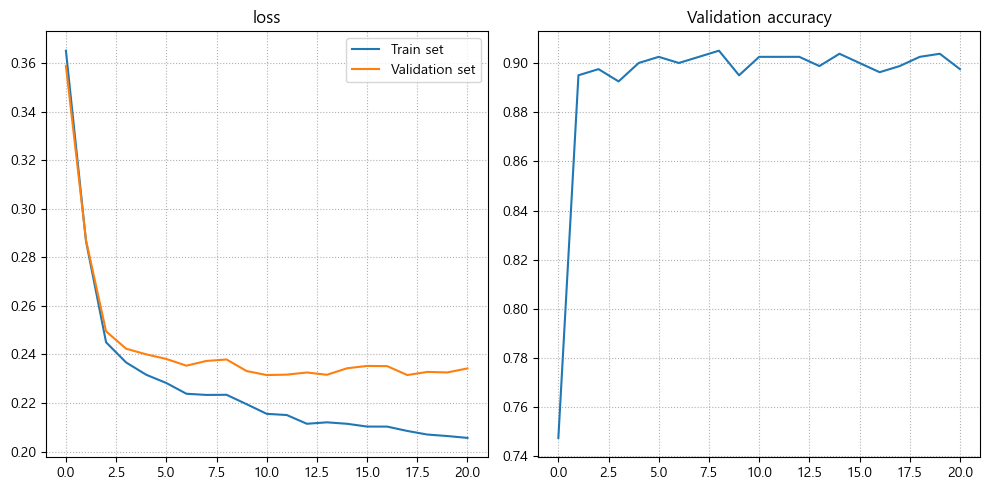

In [17]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_list, label="Train set")
plt.plot(valid_loss_list, label="Validation set")
plt.title("loss")
plt.grid(True, linestyle=":")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot( valid_acc_list)
plt.title("Validation accuracy")
plt.grid(True, linestyle=":")

plt.tight_layout()
plt.show()

In [18]:
# 모델 확인하기
dout_model.eval()
with torch.no_grad():
    y_pred = dout_model(X_valid)
    y_pred_class = (y_pred > 0.5).float()
    print(classification_report(y_valid, y_pred_class))

              precision    recall  f1-score   support

         0.0       0.93      0.94      0.93       598
         1.0       0.81      0.78      0.79       202

    accuracy                           0.90       800
   macro avg       0.87      0.86      0.86       800
weighted avg       0.90      0.90      0.90       800

